# NHL MVP Analysis

In this project we try to use machine learning to predict winners of the Hart, Ted Lindsay, Norris, Vezina, and maybe Calder trophy. I expect Calder and Vezina are going to be very easy as there's typically only 2-3 people competing in any given year; the in-game statistics are even more heavily unbalanced in favor of the top players than for other awards.  

Hockey statistics will come from Evolving Hockey and Hockey-Reference. My general plan is to do some basic data analysis to pretend I'm doing data science, and then throw an ensemble from sklearn at it. 
In any given year, I'll take vote receiving players, and we will try to predict their vote share in the final result. 


Some preliminary comments about the data:

1) Goalies have different statistics than skaters. I will try two approaches to deal with this. In one approach, I will simply set the non-relevant stats for any given player to zero. Hopefully the models will be able to figure out that for a Center, goalie_wins has zero correlation with their vote share. In the second approach, we will train two separate models: one for goalies, and one for skaters. 

2) The vote share is a very skewed data set. For example, below are shown the NHL voting data for the Hart trophy in the 17-18 season. Vote share approximately follows $e^{-x/\xi}$. By observation, in any given year there are usually two at most "serious contenders" for Hart, and often the winner has on the order of 50 to 100% more votes than second place. This may make life challenging as a small difference in statistics between the top 2 or 3 players in any given year can lead to a dramatic difference in vote share. This is an inherent feature of the data: players vote share is not computed in a vacuum, but is heavily influenced by what other players accomplished in a given year. That likely requires much more sophisticated analysis. 

In [2]:
# imports
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import os
import time
import csv 
import sklearn
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from sklearn.ensemble import (RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor)
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import (KFold, train_test_split, cross_val_score)
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from bs4 import BeautifulSoup


warnings.filterwarnings('ignore')
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

%matplotlib inline
py.init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 500)
os.environ['KMP_DUPLICATE_LIB_OK']='True'


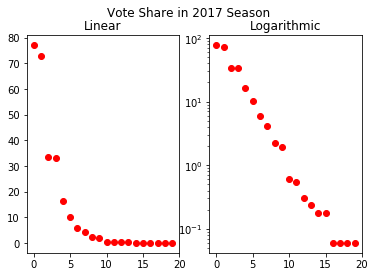

In [3]:
sample_vote = pd.read_csv("2017mvp.csv")
vote_share = sample_vote["Vote%"]

fig = plt.figure()

ax = plt.subplot(121)
ax.plot(vote_share,'ro')
ax.set_title("Linear")
plt.suptitle("Vote Share in 2017 Season")

ax=plt.subplot(122)
ax.semilogy(vote_share,'ro')
ax.set_title("Logarithmic")
plt.show()

In [4]:
try:
    full_data= pd.read_csv("hockey-data-hart.csv")    
except:

    #Scrape data
    # specify the url
    years = range(1924,2018 + 1)
    addresses = ["https://www.hockey-reference.com/awards/voting-{}.html#all-hart-stats".format(yr) for yr in years]
    names = ['Year',  
             'player',
             'age',
             'team_id',
             'pos',
             'votes',
             'pct_of_vote',
             'first',
             'second',
             'third',
             'fourth',
             'fifth',
             'goals',
             'assists',
             'points',
             'plus_minus',
             'wins_goalie',
             'losses_goalie',
             'ties_goalie',
             'goals_against_avg',
             'save_pct',
             'ops',
             'dps',
             'gps',
             'ps']

    with open('hockey-data-hart.csv', 'w') as csvfile:    #Create the csv file
        hockeywriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        hockeywriter.writerow(names)
        for i, pg in enumerate(addresses):
            time.sleep(1) #pause the code for a sec
            r = requests.get(pg)
            # parse the html using beautiful soup and store in variable `soup`
            soup = BeautifulSoup(r.text, "html.parser")
            values = [years[i]]  #first value

            #Go through the stats and add them to a list
            for tag in soup.findAll("td"):
                if tag.string == 'None': #don't save 'None' string
                    values.append('') 
                elif tag['data-stat']=='team_id': #use proper team name
                    try: #though it may not exist
                        values.append(tag.contents[0]['title'])
                    except:
                        values.append(tag.string)
                else:
                    values.append(tag.string)
                if tag['data-stat']=='ps': #if last value in row start on next line
                    hockeywriter.writerow(values)
                    values = [years[i]]  #set first value again     

In [5]:
# clean it up
full_data=full_data.dropna(axis=0,subset=['pct_of_vote'])
full_data=full_data.drop(['first','second','third','fourth','fifth'],axis=1)
full_data = full_data[full_data["pct_of_vote"]>0]
full_data["votepct_log"] = np.log(full_data["pct_of_vote"])

# let's also drop goalies who are missing save pct, and skaters who are missing plus_minus
full_data = full_data.loc[~((full_data.pos=="G") & full_data.save_pct.isna())]
full_data = full_data.loc[~((full_data.pos!="G") & full_data.plus_minus.isna())]

# remaining na's should be due to mismatched position with stats. set them to zero
full_data = full_data.fillna(0)

# for non goalies (goalies), let's replace all goalie (non goalie) stats by zero rather than NaN

# Create a new feature p_simp
def pos_combine(name):
    title_search = re.search('(^[A-Z]{1,2})', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

full_data["pos_simp"] = full_data["pos"].apply(pos_combine)
   
full_data.sample(10)

,Year,player,age,team_id,pos,votes,pct_of_vote,goals,assists,points,plus_minus,wins_goalie,losses_goalie,ties_goalie,goals_against_avg,save_pct,ops,dps,gps,ps,votepct_log,pos_simp
787,2004,Joe Thornton,24,Boston Bruins,C,37.0,3.52,23,50,73,18.0,0.0,0.0,0.0,0.00,0.000,6.3,2.5,0.0,8.8,1.258461,C
703,2000,Nicklas Lidstrom,29,Detroit Red Wings,D,22.0,3.79,20,53,73,19.0,0.0,0.0,0.0,0.00,0.000,7.1,5.8,0.0,13.0,1.332366,D
629,1996,Vladimir Konstantinov,28,Detroit Red Wings,D,3.0,0.56,14,20,34,60.0,0.0,0.0,0.0,0.00,0.000,2.6,8.5,0.0,11.1,-0.579818,D
981,2012,Jamie Benn,22,Dallas Stars,LW,2.0,0.13,26,37,63,15.0,0.0,0.0,0.0,0.00,0.000,6.2,2.0,0.0,8.2,-2.040221,LW
992,2013,Martin St. Louis,37,Tampa Bay Lightning,RW,20.0,1.12,17,43,60,0.0,0.0,0.0,0.0,0.00,0.000,5.4,0.8,0.0,6.3,0.113329,RW
218,1962,Bobby Hull,23,Chicago Black Hawks,LW,53.0,16.36,50,34,84,10.0,0.0,0.0,0.0,0.00,0.000,8.8,1.2,0.0,10.0,2.794839,LW
1018,2014,Tyler Seguin,22,Dallas Stars,C,84.0,6.13,37,47,84,16.0,0.0,0.0,0.0,0.00,0.000,9.3,2.2,0.0,11.6,1.813195,C
895,2009,Henrik Zetterberg,28,Detroit Red Wings,C,6.0,0.45,31,42,73,13.0,0.0,0.0,0.0,0.00,0.000,6.4,1.7,0.0,8.1,-0.798508,C
178,1956,Gump Worsley,26,New York Rangers,G,72.0,22.43,0,0,0,0.0,32.0,28.0,10.0,2.83,0.923,0.0,0.0,8.8,8.8,3.110399,G
1074,2016,Joe Pavelski,31,San Jose Sharks,C,8.0,0.53,38,40,78,25.0,0.0,0.0,0.0,0.00,0.000,8.4,3.0,0.0,11.5,-0.634878,C


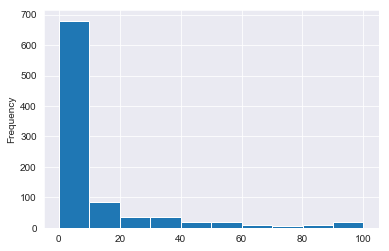

In [172]:
full_data[full_data['pct_of_vote']>0]['pct_of_vote'].plot.hist()

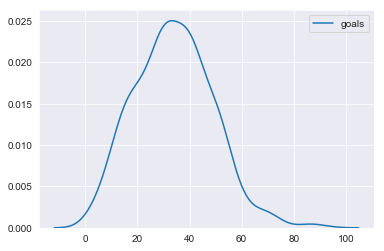

In [179]:
fd = full_data
sns.kdeplot(fd[fd['goals']>0]['goals'])

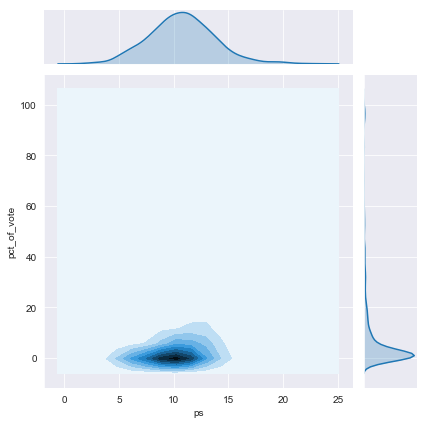

In [174]:
sns.jointplot(x='ps',y='pct_of_vote',data = fd[(fd['ps']>0) & (fd['pct_of_vote']>0)], kind='kde', gridsize=20)

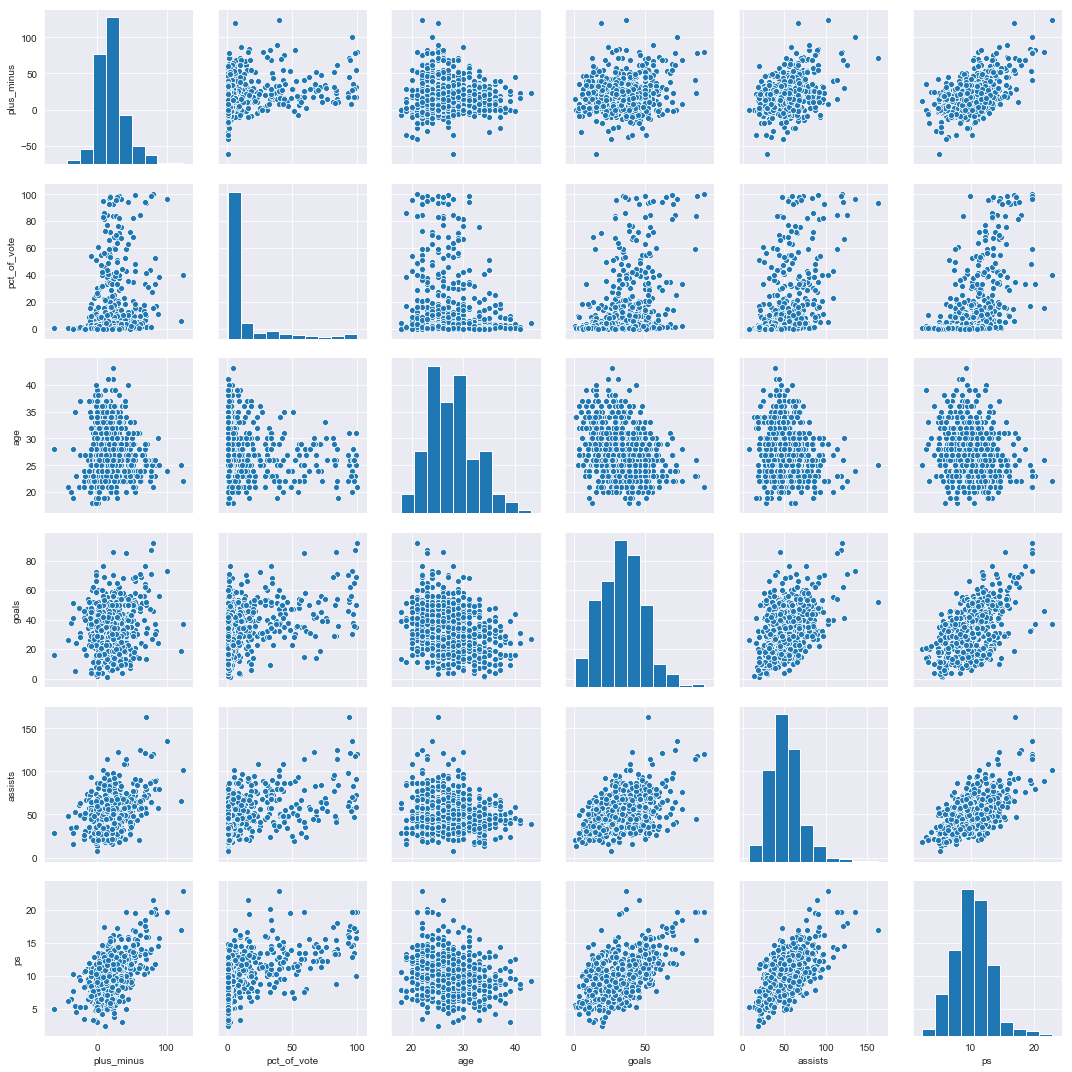

In [180]:
# examining some skater data
skaters = full_data[full_data['pos']!='G']
sns.pairplot(skaters[['plus_minus','pct_of_vote','age','goals', 'assists','ps']])


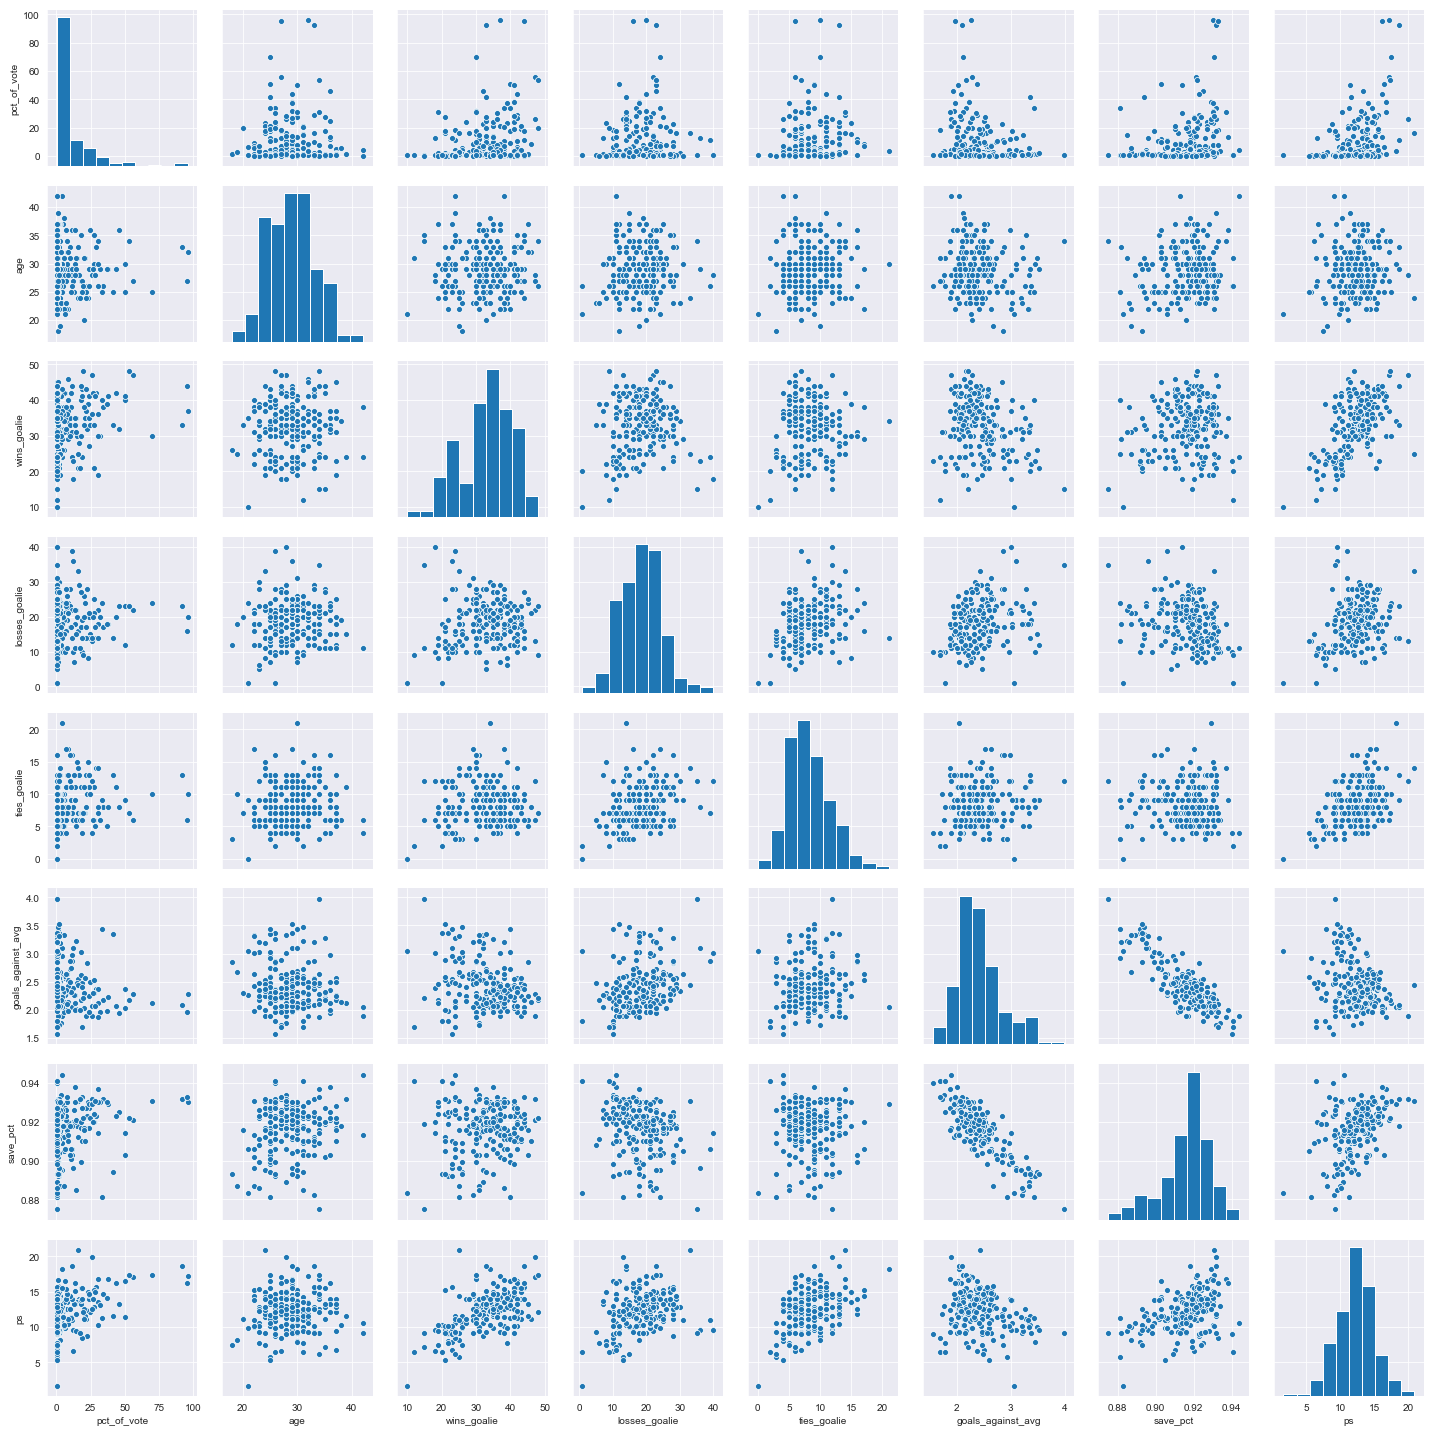

In [175]:
# plotting some goalie data
goalies = full_data[full_data['pos']=='G']
sns.pairplot(goalies[['pct_of_vote','age','wins_goalie','losses_goalie','ties_goalie','goals_against_avg','save_pct','ps']])

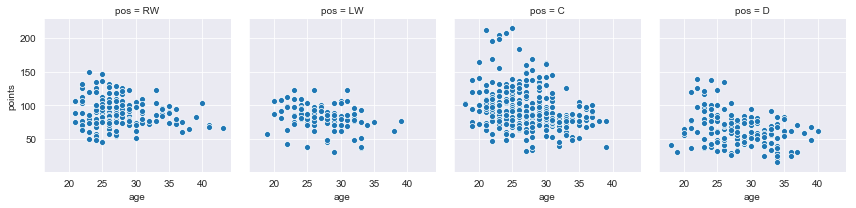

In [181]:
non_goalies = full_data[full_data["goals"]>0]
ng = non_goalies[non_goalies['pos'].isin(["C","RW","LW","D"])]

g = sns.FacetGrid(ng,col="pos")
g.map(sns.scatterplot, 'age','points')

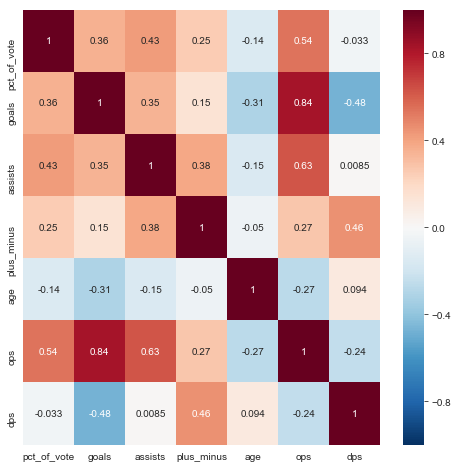

In [182]:
fd = skaters
features= ['pct_of_vote','goals','assists','plus_minus','age','ops','dps','pos']
fd = fd[features]
f = fd.corr()
plt.figure(figsize=(len(features),len(features)))

sns.heatmap(f,annot=True,cmap="RdBu_r",vmin=-1,vmax=1);

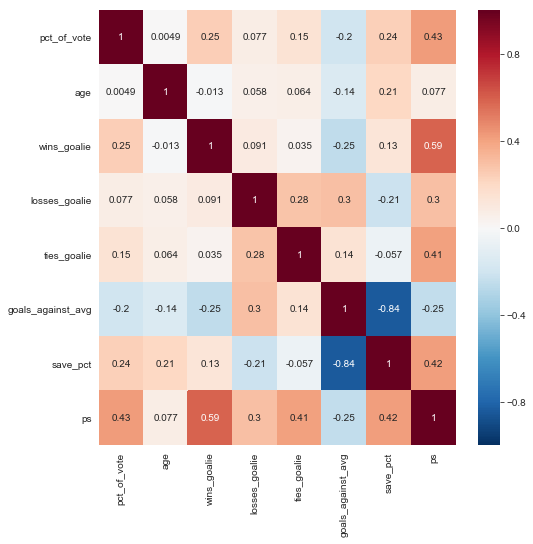

In [183]:
fd = goalies
features= ['pct_of_vote','age','wins_goalie','losses_goalie',
           'ties_goalie','goals_against_avg','save_pct','ps']
fd = fd[features]
f = fd.corr()
plt.figure(figsize=(len(features),len(features)));

sns.heatmap(f,annot=True,cmap="RdBu_r",vmin=-1,vmax=1);

In [184]:
# prepare for applying model:
# 1) one-hot encode positions
full_data=pd.get_dummies(full_data,columns=['pos_simp'])

In [185]:
fd = full_data[full_data['pct_of_vote']>0]

y = fd.pct_of_vote
model_features = [ u'age', u'goals', u'assists',  u'plus_minus',
       u'wins_goalie', u'losses_goalie', u'ties_goalie', u'goals_against_avg',
       u'save_pct', u'ops', u'dps', u'gps', u'pos_simp_C',
       u'pos_simp_D', u'pos_simp_G', u'pos_simp_LW', u'pos_simp_RW']

x= fd[model_features]

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25)

In [187]:
#Try several models
forest_model = RandomForestRegressor()
forest_model.fit(x_train,y_train)
predictions = forest_model.predict(x_test)
print("Mean Absolute error for logarithmically reweighted vote_pct")
print("Random Forest: %f" % mean_absolute_error(predictions,y_test))

xgbmodel = XGBRegressor(n_estimators=1000)
xgbmodel.fit(x_train,y_train,early_stopping_rounds=5, 
             eval_set=[(x_test, y_test)],verbose=False)
predictions = xgbmodel.predict(x_test)
print("XGBoost Regressor: %f"% mean_absolute_error(predictions,y_test))

nnmodel = MLPRegressor(hidden_layer_sizes=(100,2))
nnmodel.fit(x_train,y_train)
preds = nnmodel.predict(x_test)
print("MLP Regressor: %f"% mean_absolute_error(preds,y_test))
# print("Mean Absolute Error in actual vote_pct from xgboost: %f" % np.exp(mean_absolute_error(predictions,y_test)))

Mean Absolute error for logarithmically reweighted vote_pct
Random Forest: 9.959039
XGBoost Regressor: 9.599942
MLP Regressor: 10.401039


In [188]:
fd= full_data   
fd.describe()

,Year,age,votes,pct_of_vote,goals,assists,points,plus_minus,wins_goalie,losses_goalie,ties_goalie,goals_against_avg,save_pct,ops,dps,gps,ps,votepct_log,pos_simp_C,pos_simp_D,pos_simp_G,pos_simp_LW,pos_simp_RW
count,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000
mean,1994.758433,27.805223,86.720348,11.402818,26.317737,40.129489,66.447225,15.565832,7.471164,4.194777,1.893362,0.550326,0.208331,5.939935,2.019369,2.794777,10.755822,0.848422,0.339499,0.161045,0.227421,0.107726,0.164309
std,16.189186,4.474344,209.790484,20.733008,19.411023,26.820504,42.982405,20.033680,14.232928,8.312139,3.812254,1.033460,0.384239,4.028367,1.896366,5.323442,2.980201,1.950116,0.473797,0.367772,0.419395,0.310203,0.370758
min,1956.000000,18.000000,1.000000,0.060000,0.000000,0.000000,0.000000,-62.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000,1.700000,-2.813411,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1982.000000,25.000000,3.000000,0.495000,9.000000,21.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.400000,0.800000,0.000000,8.800000,-0.703657,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1998.000000,27.000000,13.000000,1.970000,28.000000,43.000000,75.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.700000,1.700000,0.000000,10.700000,0.678034,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2009.000000,31.000000,58.000000,10.840000,40.000000,57.000000,94.000000,25.500000,0.000000,0.000000,0.000000,0.000000,0.000000,8.850000,2.600000,0.000000,12.600000,2.383232,1.000000,0.000000,0.000000,0.000000,0.000000
max,2018.000000,43.000000,1604.000000,100.000000,92.000000,163.000000,215.000000,124.000000,48.000000,40.000000,21.000000,3.980000,0.944000,17.700000,9.900000,20.900000,22.800000,4.605170,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# testing out some stuff
fd = full_data
# do a year-by-year scaling of all numerical features
full_data.Year.unique()

numerical_columns = fd.select_dtypes(include=['float64','int64']).columns
object_columns = fd.select_dtypes(include=['object']).columns

fds = pd.DataFrame()
fds[numerical_columns] = fd[numerical_columns]

groups = fds.groupby('Year')
scaled = groups.transform(sklearn.preprocessing.scale)

fdo = fd[object_columns]
fdo["Year"] = fd["Year"]

fd_scaled = fdo.join(scaled)

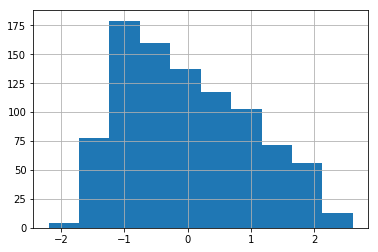

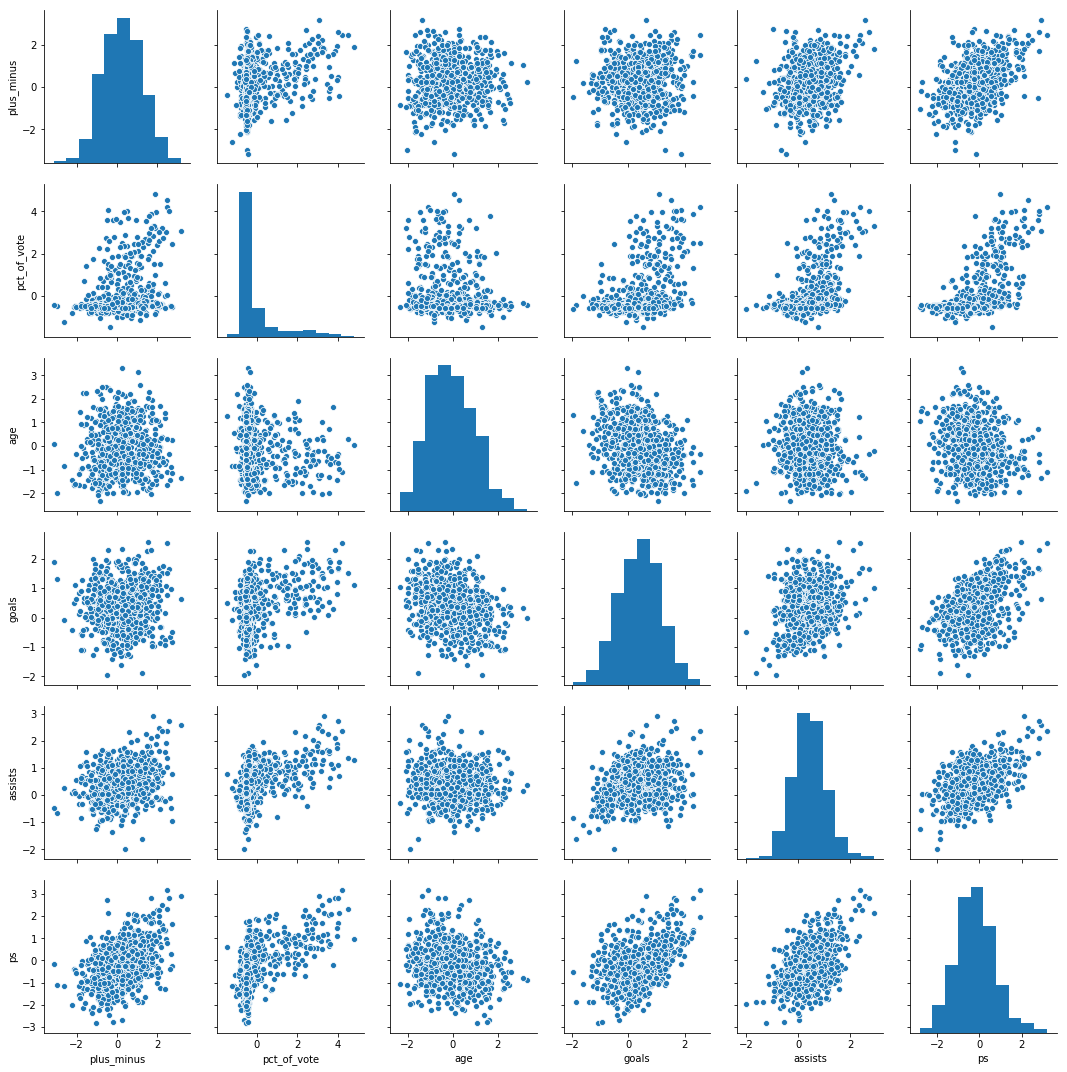

In [7]:
fd_scaled.votepct_log.hist()
skaters = fd_scaled[fd_scaled['pos']!='G']
sns.pairplot(skaters[['plus_minus','pct_of_vote','age','goals', 'assists','ps']]);

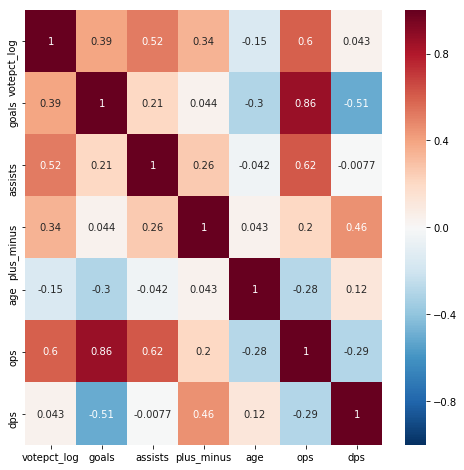

In [8]:
features= ['votepct_log','goals','assists','plus_minus','age','ops','dps','pos']
ff = skaters[features]
f = ff.corr()
plt.figure(figsize=(len(features),len(features)))

sns.heatmap(f,annot=True,cmap="RdBu_r",vmin=-1,vmax=1);

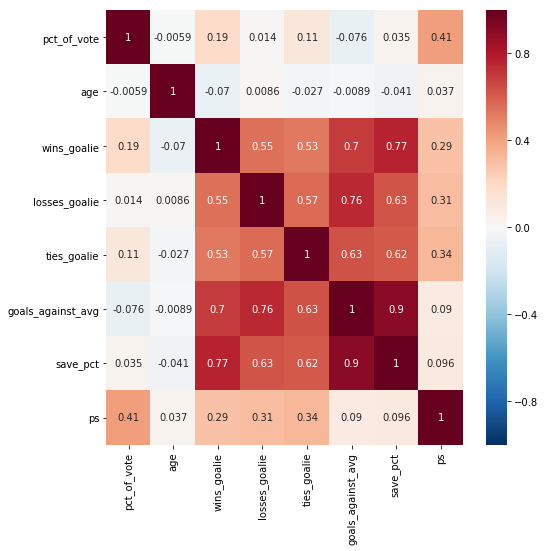

In [9]:
goalies = fd_scaled[fd_scaled['pos']=='G']

features= ['pct_of_vote','age','wins_goalie','losses_goalie','ties_goalie','goals_against_avg','save_pct','ps']
ff = goalies[features]
f = ff.corr()
plt.figure(figsize=(len(features),len(features)))

sns.heatmap(f,annot=True,cmap="RdBu_r",vmin=-1,vmax=1);

In [10]:
# prepare for applying model:
# 1) one-hot encode positions
fd=pd.get_dummies(fd_scaled,columns=['pos_simp'])

In [11]:
y = fd.pct_of_vote
model_features = [ u'age', u'goals', u'assists',  u'plus_minus',
       u'wins_goalie', u'losses_goalie', u'ties_goalie', u'goals_against_avg',
       u'save_pct', u'ops', u'dps', u'gps', u'pos_simp_C',
       u'pos_simp_D', u'pos_simp_G', u'pos_simp_LW', u'pos_simp_RW']

X= fd[model_features]
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

train, test = train_test_split(fd, test_size=0.25)

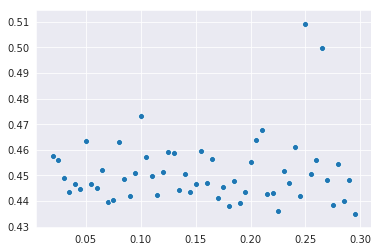

In [12]:
#optimizing learning rate for xgboost
learnRange = np.arange(0.02, 0.3, 0.005)
xgb_mae = np.zeros(learnRange.shape)
for idx, alpha in enumerate(learnRange):
    xgbmodel = XGBRegressor(n_estimators=1000, learning_rate=alpha)
    xgbmodel.fit(x_train,y_train,early_stopping_rounds=5, 
                 eval_set=[(x_test, y_test)],verbose=False)
    predictions = xgbmodel.predict(x_test)
    xgb_mae[idx] = mean_absolute_error(predictions,y_test)
    
with sns.axes_style("darkgrid"):
    sns.scatterplot(x=learnRange,y=xgb_mae)

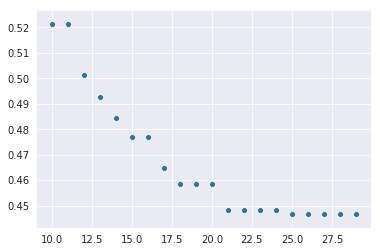

In [13]:
#optimizing n_estimators
nRange = np.arange(10,30,1)
xgb_mae = np.zeros(nRange.shape)
for idx, nest in enumerate(nRange):
    xgbmodel = XGBRegressor(n_estimators=nest, learning_rate=0.15)
    xgbmodel.fit(x_train,y_train,early_stopping_rounds=5, 
                 eval_set=[(x_test, y_test)],verbose=False)
    predictions = xgbmodel.predict(x_test)
    xgb_mae[idx] = mean_absolute_error(predictions,y_test)
    
with sns.axes_style("darkgrid"):
    sns.scatterplot(x=nRange,y=xgb_mae)

In [14]:
#Using cross-validation as this is a small data set

print("Mean Absolute error for logarithmically reweighted vote_pct")

RF_pipeline = make_pipeline(RandomForestRegressor(n_estimators=100))
scores = cross_val_score(RF_pipeline, X, y, scoring='neg_mean_absolute_error')
print('Random Forest: %2f' %(-1 * scores.mean()))

XGB_pipeline = make_pipeline(XGBRegressor(n_estimators=24,learning_rate = 0.16))
scores = cross_val_score(XGB_pipeline, X, y, scoring='neg_mean_absolute_error')
print('XGBoost: %2f' %(-1 * scores.mean()))

MLP_pipeline = make_pipeline(Imputer(), MLPRegressor(hidden_layer_sizes=(20,4,4)))
scores = cross_val_score(MLP_pipeline, X, y, scoring='neg_mean_absolute_error')
print('MLP: %2f' %(-1 * scores.mean()))

Mean Absolute error for logarithmically reweighted vote_pct
Random Forest: 0.469775
XGBoost: 0.458943
MLP: 0.516204


In [15]:
fd



,player,team_id,pos,Year,age,votes,pct_of_vote,goals,assists,points,plus_minus,wins_goalie,losses_goalie,ties_goalie,goals_against_avg,save_pct,ops,dps,gps,ps,votepct_log,pos_simp_C,pos_simp_D,pos_simp_G,pos_simp_LW,pos_simp_RW
178,Gump Worsley,New York Rangers,G,1956,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0
189,Terry Sawchuk,Boston Bruins,G,1957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0
196,Glenn Hall,Chicago Black Hawks,G,1958,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0
204,Terry Sawchuk,Detroit Red Wings,G,1959,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0
206,Gordie Howe,Detroit Red Wings,RW,1960,0.688062,1.900210,1.900180,0.340297,0.911373,0.658094,0.344520,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,0.510752,0.602213,-0.500000,-0.308599,1.731054,0,0,0,0,1
207,Bobby Hull,Chicago Black Hawks,LW,1960,-1.769303,0.017927,0.017880,1.120145,0.731497,0.921332,1.291952,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,1.027969,0.833834,-0.500000,0.215437,0.314142,0,0,0,1,0
208,Glenn Hall,Chicago Black Hawks,G,1960,-0.049147,-0.310726,-0.310466,-1.644770,-1.726812,-1.711045,-1.033561,2.000000,2.000000,2.000000,2.000000,2.000000,-1.558117,-1.945612,2.000000,1.612866,-0.099606,0,0,1,0,0
209,Jean Beliveau,Montreal Canadiens,C,1960,-0.049147,-0.788766,-0.789168,0.765669,0.611579,0.690999,0.689041,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,0.801687,0.370593,-0.500000,-0.017468,-0.939743,1,0,0,0,0
210,Bert Olmstead,Toronto Maple Leafs,LW,1960,1.179536,-0.818644,-0.818426,-0.581341,-0.527637,-0.559380,-1.291952,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.782291,0.138972,-0.500000,-1.502236,-1.005847,0,0,0,1,0
211,Bernie Geoffrion,Montreal Canadiens,RW,1961,-0.187729,1.244241,1.244125,1.176428,0.878313,1.077584,-0.123143,-0.813679,-0.782508,-0.774278,-0.816472,-0.816496,1.235904,0.727171,-0.811419,0.221456,1.058441,0,0,0,0,1
